In [1]:
import numpy as np
import os
import random
import pandas as pd

state_list = ['alabama','arizona', 'arkansas','idaho','indiana', 'iowa', 'kentucky', 'michigan','minnesota', 'mississippi', 'nebraska','new mexico','ohio','oklahoma','south carolina', 'tennessee', 'texas', 'utah','virginia','wisconsin']
state_abbr = ['AL','AZ','AR','ID','IN','IA','KY','MI','MN','MS','NE','NM','OH','OK','SC','TN','TX','UT','VA','WI']
data_folder = '../datasets/US/epedimic/'
suffix = 'cases.csv'
data_paths = {state: data_folder + state + '_' + suffix for state in state_list}
data_dict = {state: pd.read_csv(path) for state, path in data_paths.items()}
pop_list = {state: data_dict[state]['Population'].iloc[0] for state in state_list}
pop_list


{'alabama': 4903185,
 'arizona': 7278717,
 'arkansas': 3017804,
 'idaho': 1787065,
 'indiana': 6732219,
 'iowa': 3155070,
 'kentucky': 4467673,
 'michigan': 9986857,
 'minnesota': 5639632,
 'mississippi': 2976149,
 'nebraska': 1934408,
 'new mexico': 2096829,
 'ohio': 11689100,
 'oklahoma': 3956971,
 'south carolina': 5148714,
 'tennessee': 6829174,
 'texas': 28995881,
 'utah': 3205958,
 'virginia': 8535519,
 'wisconsin': 5822434}

In [5]:
from scipy.stats import gamma
from scipy.stats import gamma as gamma_dist

def obtain_metrics(gt_df, cols=['Q_gt', 'D_gt', 'R_gt'], pop=100000):
    gt_df['Confirmed'] = gt_df[cols].sum(axis=1)
    gt_df['new_cases'] = gt_df['Confirmed'].diff().fillna(0)
    gt_df.loc[gt_df['new_cases'] < 0, 'new_cases'] = 0  # 修正负值
    gt_df['incidence_rate'] = gt_df['new_cases'] / pop * 100000
    gt_df['incidence_rate_7d'] = gt_df['incidence_rate'].rolling(window=7, min_periods=1).mean()
    gt_df['active_case_ratio'] = gt_df[cols[0]] / pop * 100000
    gt_df['new_deaths'] = gt_df[cols[1]].diff().clip(lower=0)
    gt_df['death_incidence_per100k'] = gt_df['new_deaths'] / pop * 100000
    gt_df['death_incidence_7d'] = gt_df['death_incidence_per100k'].rolling(7, min_periods=1).mean()
    return gt_df

def estimate_Rt(gt_df, cols=['Q_gt', 'D_gt', 'R_gt'], window=21, pop = 100000, eps = 1e-12):
    gt_df = gt_df.copy()
    gt_df = obtain_metrics(gt_df, cols, pop)
    # 设定代际时间分布参数
    mean_si, sd_si = 5, 2   ##从感染者发病，到其传染的下一代人发病的时间间隔
    shape = (mean_si / sd_si)**2
    scale = (sd_si**2) / mean_si
    # 离散化 1-20 天
    w = [gamma.cdf(s+1, a=shape, scale=scale) - gamma.cdf(s, a=shape, scale=scale)
        for s in range(20)]
    w = np.array(w)
    w /= w.sum()
    a, b = 1, 1   # Gamma先验
    I = gt_df['new_cases'].to_numpy()
    Rt_mean, Rt_low, Rt_high = [], [], []
    dates = []
    for t in range(window, len(I)):
        Lambda = []
        for u in range(t-window, t):
            lam = sum(I[u-(s+1)] * w[s] for s in range(len(w)) if u-(s+1) >= 0)
            Lambda.append(lam)
        I_sum = I[t-window:t].sum()
        Lambda_sum = np.sum(Lambda)
        # 后验参数
        shape_post = a + I_sum
        rate_post  = b + max(Lambda_sum, eps)
        # 点估计和区间
        mean_R = shape_post / rate_post
        ci_low, ci_high = gamma_dist.ppf([0.025, 0.975], shape_post, scale=1/rate_post)
        Rt_mean.append(mean_R)
        Rt_low.append(ci_low)
        Rt_high.append(ci_high)
        dates.append(t)
    rt_df = pd.DataFrame({
        't': dates,
        'R_mean': Rt_mean,
        'R_low': Rt_low,
        'R_high': Rt_high
    })
    return rt_df, gt_df


In [3]:
delta_window = 21
warm_day = 10
data_folder = '../outputs/baseline-us/results/'
suffix = 'results.csv'
week_freq = '8 weeks'
results_folder = '../outputs/US//'+week_freq+'/agent/'
data_paths = {state: f"{data_folder}{state}_{suffix}" for state in state_list}
# output_folder = "D:\\Code\\OD-COVID\\figures\\R0_3week\\"
# os.makedirs(output_folder, exist_ok=True)
# all_over_df = pd.DataFrame()
state_std = {}
state_r_mean = {}
for i in range(len(state_list)):
    state = state_list[i]
    data_path = data_paths[state]
    gt_df = pd.read_csv(data_path)
    cols = ['Q_gt', 'D_gt', 'R_gt']
    rt_df, gt_df = estimate_Rt(gt_df.iloc[warm_day:], cols=cols, window=delta_window, pop=pop_list[state])
    subfolders = [f.path for f in os.scandir(results_folder) if f.is_dir()]
    policy_dfs = []
    metric_cols = ['incidence_rate_7d', 'active_case_ratio', 'death_incidence_7d']
    mean_values = []
    gt_df = gt_df[metric_cols]
    R0 = []
    for k, f in enumerate(subfolders):
        results_path = os.path.join(f, 'results')
        agent_df = pd.read_csv(f"{results_path}\\{state}_results.csv")
        ra_df, policy_df = estimate_Rt(agent_df.iloc[warm_day:], cols=['Q_pred', 'D_pred', 'R_pred'], window=delta_window, pop=pop_list[state])
        policy_dfs.append(policy_df[metric_cols])
        R0.append(ra_df['R_mean'][-100:].mean())  # Corrected to use .loc[] for label-based indexing
    names = [f'df{i+1}' for i in range(len(policy_dfs))]
    big = pd.concat(policy_dfs, axis=1, keys=names)
    row_mean = big.groupby(level=1, axis=1).mean()  
    row_std  = big.groupby(level=1, axis=1).std(ddof=1) 
    big_mean = big.mean()
    big_std = big_mean.groupby(level=1).std()
    state_std[state] = big_std
    print(R0)
    state_std[state]['R0'] = np.std(R0)
    state_r_mean[state] = np.mean(R0)
    # print(f"State: {state}")
    # print(row_mean.tail(5))
    # print(row_std.tail(5))
    # print(gt_df.tail(5))
    # print(rt_df.tail(5))
    rt_df.to_csv(f"{results_folder}{state}_R0_gt_{week_freq}.csv", index=False)
    ra_df.to_csv(f"{results_folder}{state}_R0_agent_{week_freq}.csv", index=False)
    row_mean.to_csv(f"{results_folder}{state}_metrics_mean_{week_freq}.csv", index=False)
    row_std.to_csv(f"{results_folder}{state}_metrics_std_{week_freq}.csv", index=False)
    gt_df.to_csv(f"{results_folder}{state}_metrics_gt_{week_freq}.csv", index=False)


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.0878807822371375, 1.0814432528526674, 1.0941903406651836, 1.1277137692761807]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.0554964139383043, 1.1234372398644148, 1.1711615368725965, 1.138315821050046]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.0194356072798478, 1.0289465331138918, 1.027544463766474, 1.039845623057753]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.06711463390608, 1.025649500466596, 1.1152045248716136, 1.1158623907342484]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.0100064719507065, 1.0780712548771558, 1.0423882764490708, 1.1103126384249051]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.0965574509391438, 1.1014181603910236, 1.0881497999909573, 1.0258710709084518]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.031206554400767, 1.118622863629581, 1.5465329304477842, 1.1173169536291656]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.0366971086070174, 1.0836270691802519, 1.0684142179019107, 1.0504459177593057]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.0333545925595904, 1.0553271351194295, 1.0353588565802196, 1.0480945028960555]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.0393314662911157, 1.07443942155493, 1.0522372892361183, 1.040122432578733]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.0714560018518944, 1.0968453534212486, 1.0777162090794496, 1.0540875101536111]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.0376469444153484, 1.0614366855498347, 1.0999807418655014, 1.0828161821984141]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.0257172785371056, 1.05235533042795, 1.046460237837625, 1.0233214605575953]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[0.9920068881392637, 1.069919658211628, 1.0273598193226523, 1.0631185246275467]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.053180817875512, 1.0769214222774077, 1.1397227024092487, 1.0513085181052606]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.0112497839162817, 1.0615326183568348, 1.0414630035389232, 1.0465454849245324]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.0035710537727671, 1.0244716262115086, 1.0171116325601246, 1.0240975778596095]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.0475222017597012, 1.0551099623244693, 1.0564668900785434, 1.0671018294054986]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


[1.018243189602834, 1.0637998606067787, 1.1471625638063854, 1.0638655631057121]
[1.0285800094667703, 1.0635558112752581, 1.0455448289165636, 1.020052313852297]


C:\Users\10992\AppData\Local\Temp\ipykernel_30592\1766326917.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_std  = big.groupby(level=1, axis=1).std(ddof=1)


In [6]:
import os
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    "font.family": "Times New Roman",
    "mathtext.fontset": "stix",      
    "axes.unicode_minus": False      
})

week_freq = ' 4 weeks'
results_folder = '..\\outputs\\US\\'+week_freq+'\\agent'  # 注意：尽量保持和你实际路径一致

metric_cols = ['incidence_rate_7d', 'active_case_ratio', 'death_incidence_7d', 'R0']
y_labels = ['Incidence Rate (per 100k)',
            'Active case ratio (per 100K)',
            'Daily Death Incidence (per 100K)']

# 只画 index = 1，对应 active_case_ratio
metric_idx = 2
for metric_idx in [0,1,2,3]:
    metric_name = metric_cols[metric_idx]
    ylabel = y_labels[metric_idx]
    gt_values = []      # 各州 ground truth 的平均值
    agent_values = []   # 各州 agent 的平均值
    agent_stds = []     # 各州 agent 的 std（如果有）
    for state in state_list:
        # 1. 读入该州数据
        metric_gt = pd.read_csv(os.path.join(results_folder, f"{state}_metrics_gt_{week_freq}.csv"))
        metric_mean = pd.read_csv(os.path.join(results_folder, f"{state}_metrics_mean_{week_freq}.csv"))
        metric_std = pd.read_csv(os.path.join(results_folder, f"{state}_metrics_std_{week_freq}.csv"))
        r0_gt = pd.read_csv(os.path.join(results_folder, f"{state}_R0_gt_{week_freq}.csv"))
        r0_agent = pd.read_csv(os.path.join(results_folder, f"{state}_R0_agent_{week_freq}.csv"))
        # 2. 如果你后面要用日期，可以保留；不用的话其实可以删掉这一块
        warm_day = 10
        start_date = pd.Timestamp('2020-04-12') + pd.DateOffset(days=warm_day)
        metric_gt['date'] = pd.date_range(start=start_date, periods=len(metric_gt), freq='D')
        metric_gt['date'] = pd.to_datetime(metric_gt['date'])
        metric_mean['date'] = metric_gt['date']
        metric_std['date'] = metric_gt['date']
        # 3. 计算该州在整个评估期内的平均值
        gt_mean = metric_gt[metric_cols[:3]].mean(numeric_only=True)
        agent_mean = metric_mean[metric_cols[:3]].mean(numeric_only=True)
        gt_ro_mean = r0_gt['R_mean'].mean()
        agent_ro_mean = r0_agent['R_mean'].mean()
        gt_mean['R0'] = gt_ro_mean
        # agent_mean['R0'] = agent_ro_mean
        agent_mean['R0'] = state_r_mean[state]
        gt_values.append(gt_mean[metric_name])
        agent_values.append(agent_mean[metric_name])
        agent_stds.append(state_std[state][metric_name])

    # ===== 画一张大图：x 轴 21 个州，两根柱子分别是 GT 和 Agent =====
    n_states = len(state_list)
    x = np.arange(n_states)
    width = 0.35

    color_gt = "#4F6A8A"   # muted slate blue
    color_agent = "#C08A3E"  # warm ochre / golden brown
    err_color = "#444444"    # 深灰色误差棒
    plt.figure(figsize=(20, 6))
    plt.bar(x - width/2, gt_values, width, label='Ground Truth',color=color_gt)
    plt.bar(x + width/2, agent_values, width,
            yerr=agent_stds, capsize=5,
            label='Agent', color=color_agent, error_kw={'ecolor': err_color})
    plt.xticks(x, [state.capitalize() for state in state_list], rotation=45, ha='right', fontsize=16)
    if metric_idx == 3:
        plt.ylim(0.8, 1.2)
    plt.yticks(fontsize=16)
    plt.ylabel(ylabel, fontsize=18)
    plt.title(f'All states: {metric_name}', fontsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()
    #plt.savefig(f'../figures/US/US_20_states_{metric_name}.png', dpi=300)
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '..\\outputs\\US\\ 4 weeks\\agent\\alabama_metrics_gt_ 4 weeks.csv'

# calculate for SC

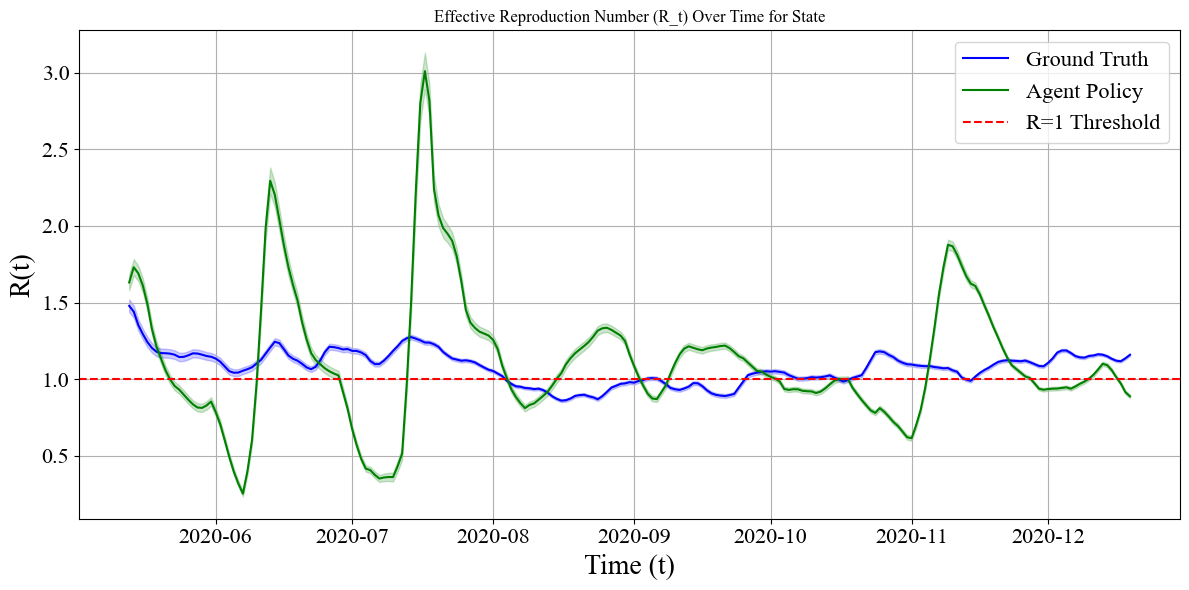

In [11]:


def plot_Rt(rt_df, ra_df, date, output_folder = None, state = 'state', base_results = None):
   '''tr_df: ground truth R_t dataframe
       ra_df: agent R_t dataframe
       rt_incidence: ground truth incidence rate series
       ra_incidence: agent incidence rate series'''
   plt.figure(figsize=(12, 6))
   plt.plot(date, rt_df['R_mean'], label='Ground Truth', color='blue')
   plt.fill_between(date, rt_df['R_low'], rt_df['R_high'], color='blue', alpha=0.2)
   plt.plot(date, ra_df['R_mean'], label='Agent Policy', color='green')
   plt.fill_between(date, ra_df['R_low'], ra_df['R_high'], color='green', alpha=0.2)
   if base_results:
      base_df = base_results
      plt.plot(date, base_df['R_mean'], label='Agent Policy (base)', color='orange', linestyle='--')
      plt.fill_between(date, base_df['R_low'], base_df['R_high'], color='orange', alpha=0.2)
   plt.axhline(1, color='red', linestyle='--', label='R=1 Threshold')
   plt.xlabel('Time (t)', fontsize=20)
   plt.ylabel('R(t)', fontsize=20)
   plt.xticks(fontsize=16)
   plt.yticks(fontsize=16)
   plt.title('Effective Reproduction Number (R_t) Over Time for ' + state.title())
   plt.legend(fontsize=16)
   plt.grid()
   plt.tight_layout()
   if output_folder:
      plt.savefig(f"{output_folder}/{state.replace(' ', '_')}_R0.png")
   plt.show()

state = state_list[0]
data_path = data_paths[state]
gt_df = pd.read_csv(data_path)
results_path = os.path.join(f, 'results')
agent_df = pd.read_csv(f"{results_path}\\{state}_results.csv")
ra_df, ra_incidence = estimate_Rt(agent_df.iloc[warm_day:], cols=['Q_pred', 'D_pred', 'R_pred'], window=delta_window, pop=pop_list[state])
start_day = pd.to_datetime('2020-04-12')
date = pd.date_range(start=start_day + pd.Timedelta(days=delta_window) + pd.Timedelta(days=warm_day), periods=len(rt_df))
rt_df, rt_incidence = estimate_Rt(gt_df.iloc[warm_day:], cols = ['Q_gt', 'D_gt', 'R_gt'], window=delta_window, pop=pop_list[state])
plot_Rt(rt_df, ra_df, date, output_folder = None, state = 'state', base_results = None)

# weeks 4 and 8 compare

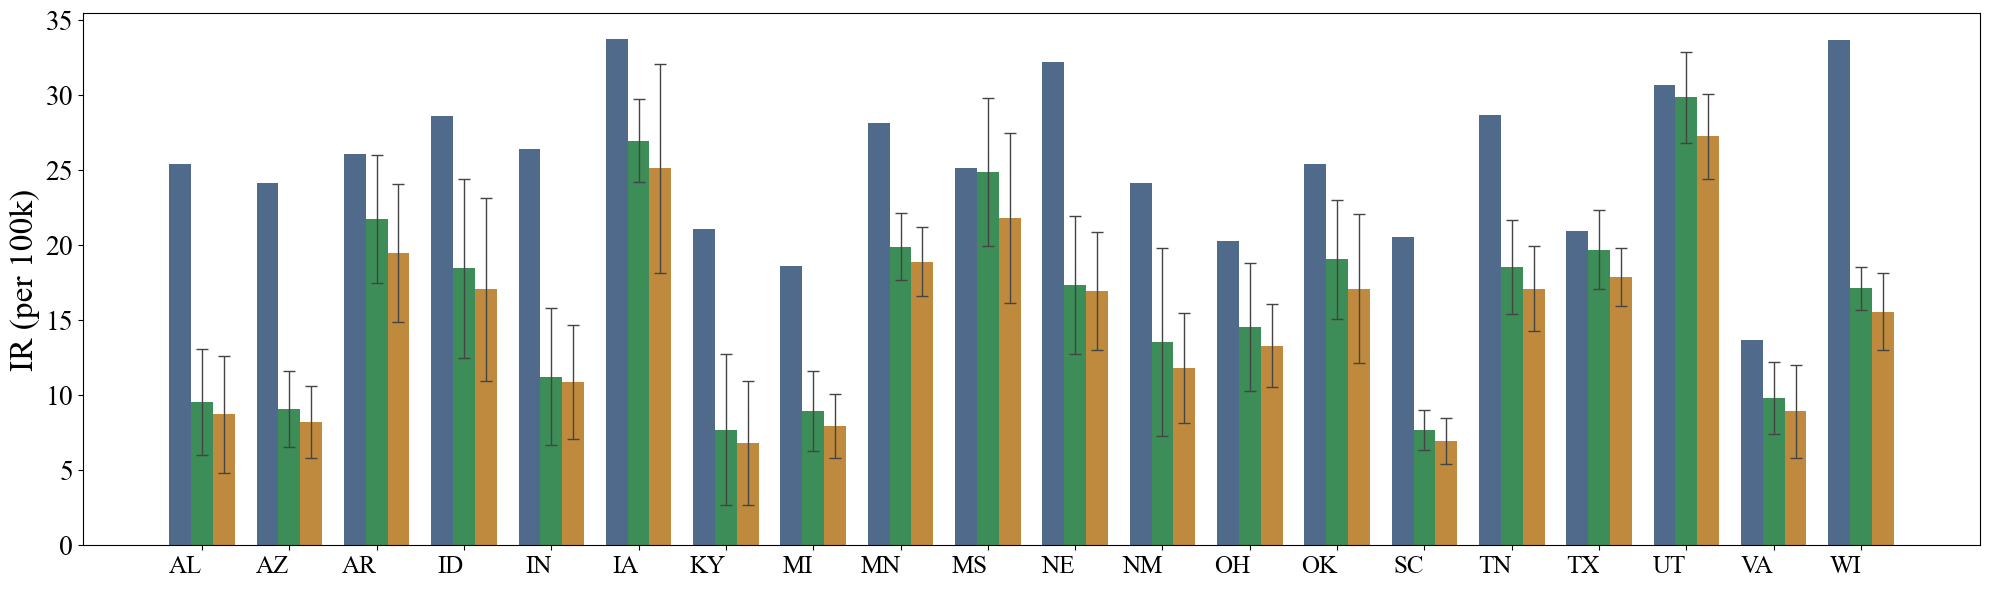

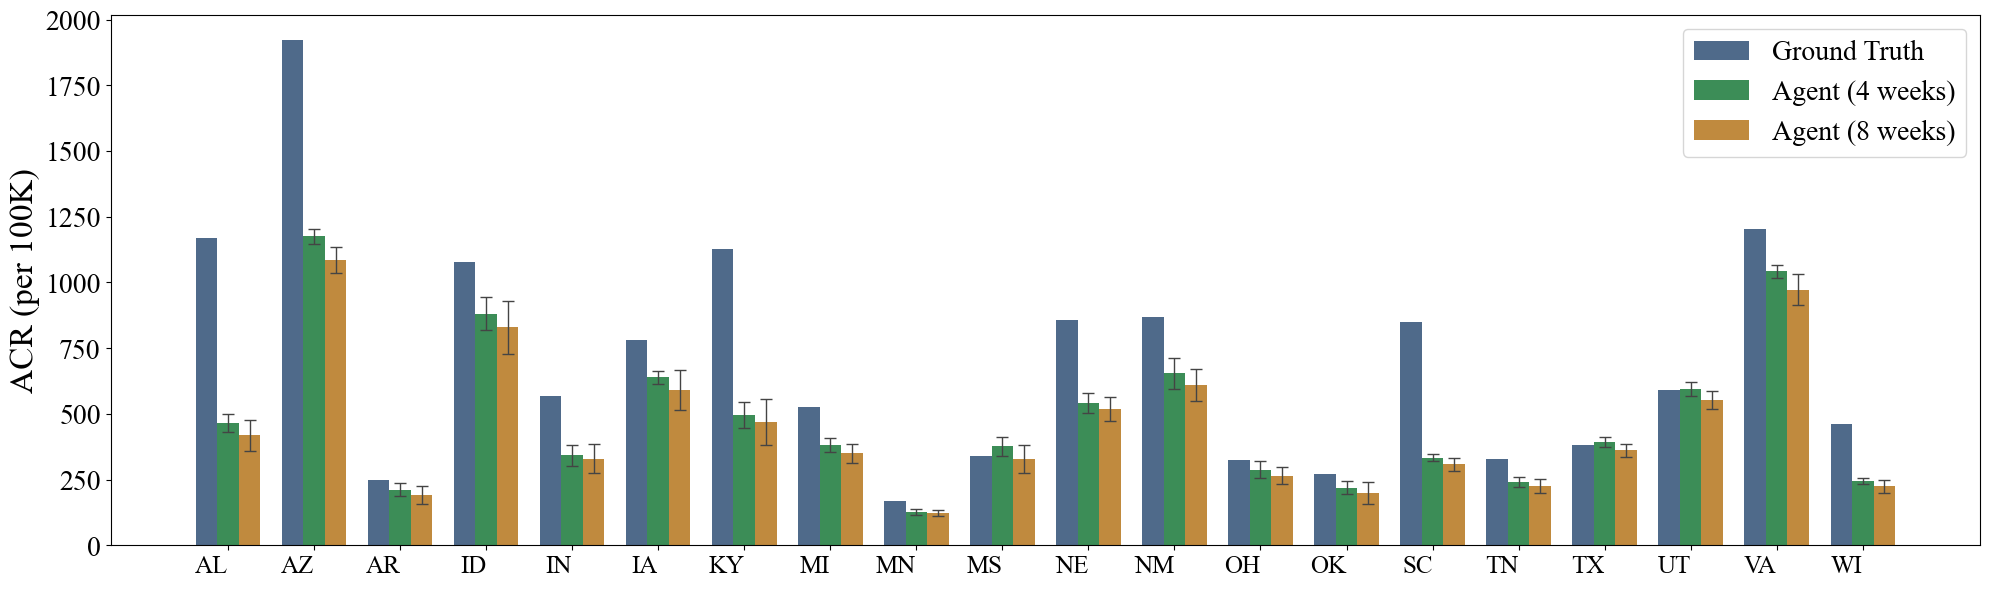

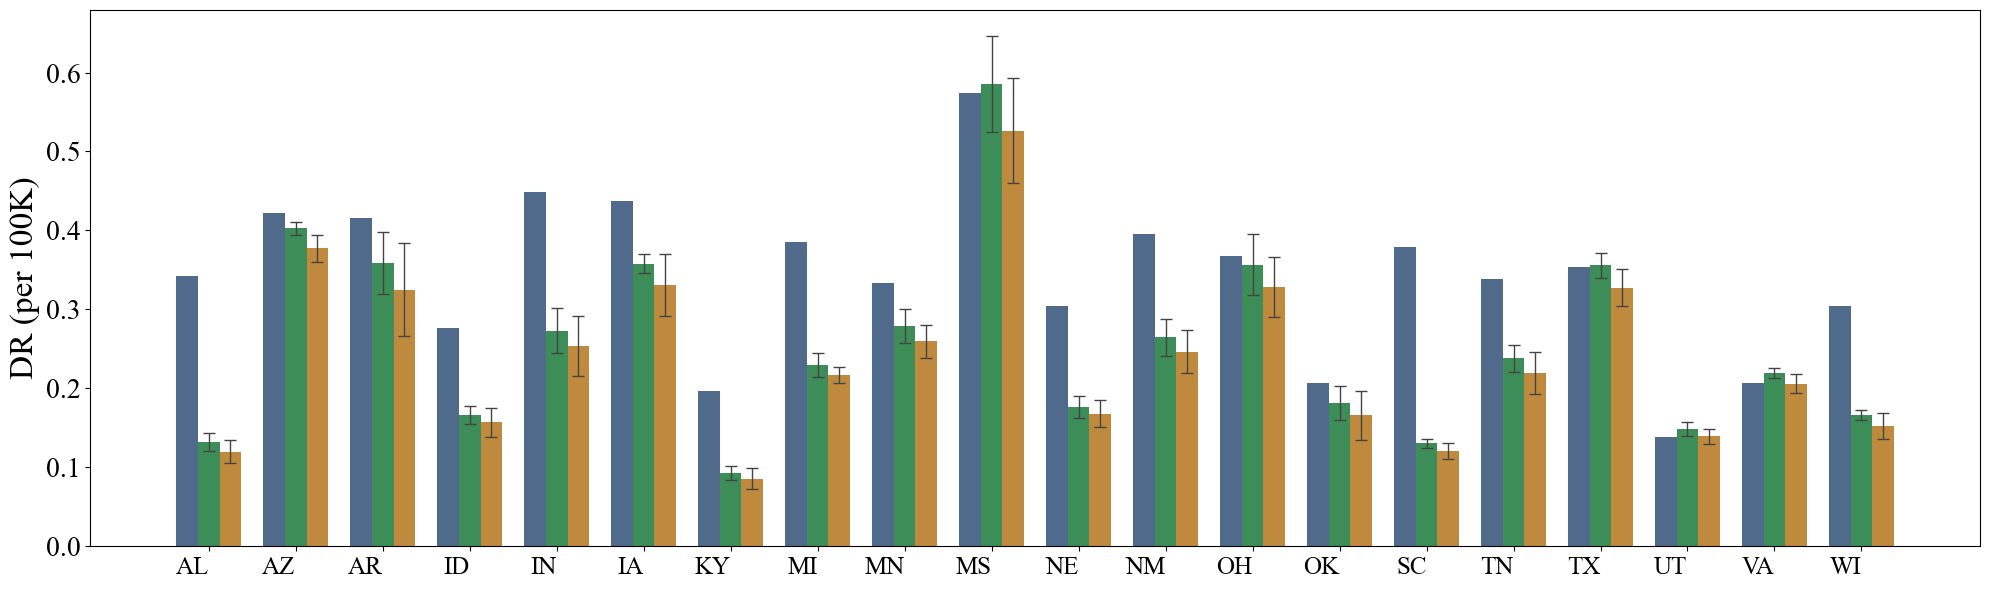

In [7]:
week_freqs = ["4 weeks", "8 weeks"]  # 这里建议文件夹名不要带空格，更干净
results_root = "..\\outputs\\US"
metric_cols = ['incidence_rate_7d', 'active_case_ratio', 'death_incidence_7d']
y_labels = [
    'IR (per 100k)',
    'ACR (per 100K)',
    'DR (per 100K)',
    'Basic reproduction number $R_0$'
]

# 配色：GT 深蓝，4w 绿色，8w 橙色
color_gt     = "#4F6A8A"   # muted slate blue
color_4weeks = "#3C8D57"   # green-ish
color_8weeks = "#C08A3E"   # warm ochre
err_color    = "#444444"   # 深灰误差棒

# ========== 主循环：对每个 metric 画一张大图 ==========
for metric_idx, metric_name in enumerate(metric_cols):
    ylabel = y_labels[metric_idx]

    # 这三个列表都按 state_list 的顺序存值
    gt_values = []          # 各州 ground truth 的平均值（同一份，不随 freq 变）
    agent_values_4 = []     # 4 weeks agent 的平均值
    agent_values_8 = []     # 8 weeks agent 的平均值
    agent_stds_4 = []       # 4 weeks agent 的 std
    agent_stds_8 = []       # 8 weeks agent 的 std
    # --------- 遍历各州，计算 gt / agent-4 / agent-8 ----------
    for state in state_list:
        # 1) 对每个 freq 分别读文件
        vals_gt_state = None    # 只计算一次 GT
        vals_agent = {}         # { '4weeks': (mean, std), '8weeks': (mean, std) }
        for wf in week_freqs:
            results_folder = os.path.join(results_root, wf, "agent")
            metric_gt = pd.read_csv(os.path.join(results_folder, f"{state}_metrics_gt_{wf}.csv"))
            metric_mean = pd.read_csv(os.path.join(results_folder, f"{state}_metrics_mean_{wf}.csv"))
            metric_std = pd.read_csv(os.path.join(results_folder, f"{state}_metrics_std_{wf}.csv"))
            r0_gt = pd.read_csv(os.path.join(results_folder, f"{state}_R0_gt_{wf}.csv"))
            r0_agent = pd.read_csv(os.path.join(results_folder, f"{state}_R0_agent_{wf}.csv"))
            # ---- ground truth 只用一次（两个 wf 的 GT 理论相同，这里用 4weeks 的那套即可）----
            if vals_gt_state is None:
                # 评估期内三个流行病学指标的平均值
                gt_mean_3 = metric_gt[['incidence_rate_7d', 'active_case_ratio', 'death_incidence_7d']].mean(numeric_only=True)
                gt_r0_mean = r0_gt['R_mean'].mean()
                gt_mean_3['R0'] = gt_r0_mean
                vals_gt_state = gt_mean_3
            # ---- agent 的 mean & std ----
            agent_mean_3 = metric_mean[['incidence_rate_7d', 'active_case_ratio', 'death_incidence_7d']].mean(numeric_only=True)
            agent_std_3  = metric_std[['incidence_rate_7d', 'active_case_ratio', 'death_incidence_7d']].mean(numeric_only=True)
            agent_r0_mean = r0_agent['R_mean'].mean()
            agent_mean_3['R0'] = agent_r0_mean
            # R0 暂时不设 std，或者你可以自己用 bootstrap 估计；这里先给 0
            agent_std_3['R0'] = 0.0
            vals_agent[wf] = (agent_mean_3, agent_std_3)
        # 2) 将该州的值填入对应列表
        gt_values.append(vals_gt_state[metric_name])
        agent_values_4.append(vals_agent['4 weeks'][0][metric_name])
        agent_stds_4.append(vals_agent['4 weeks'][1][metric_name])
        agent_values_8.append(vals_agent['8 weeks'][0][metric_name])
        agent_stds_8.append(vals_agent['8 weeks'][1][metric_name])

    # ---------- 开始画图：一张大图，三类柱子（GT / 4w / 8w） ----------
    n_states = len(state_list)
    x = np.arange(n_states)
    width = 0.25
    plt.figure(figsize=(20, 6))
    # Ground Truth
    plt.bar(x - width, gt_values, width,
            label='Ground Truth',
            color=color_gt)
    # Agent 4weeks
    plt.bar(x,
            agent_values_4, width,
            yerr=agent_stds_4,
            capsize=4,
            label='Agent (4 weeks)',
            color=color_4weeks,
            error_kw={'ecolor': err_color, 'elinewidth': 1})
    # Agent 8weeks
    plt.bar(x + width,
            agent_values_8, width,
            yerr=agent_stds_8,
            capsize=4,
            label='Agent (8 weeks)',
            color=color_8weeks,
            error_kw={'ecolor': err_color, 'elinewidth': 1})
    # x 轴标签
    plt.xticks(
        x,
        # [state.capitalize() for state in state_list],
        state_abbr,
        # rotation=45,
        ha='right',
        fontsize=18
    )
    # R0 可以限定一个比较合理的范围，避免柱子太扁
    if metric_name == 'R0':
        plt.ylim(0.8, 1.6)
    plt.yticks(fontsize=20)
    plt.ylabel(ylabel, fontsize=24)
    plt.xticks(fontsize=18)
    #plt.title(f'All states: {metric_name}', fontsize=18)
    if metric_idx == 1:
        plt.legend(fontsize=20)
    plt.tight_layout()
    # 如果需要保存：
    out_fig_path = f'../figures/US/US_states_{metric_name}_4vs8weeks.png'
    plt.savefig(out_fig_path, dpi=300)

    plt.show()

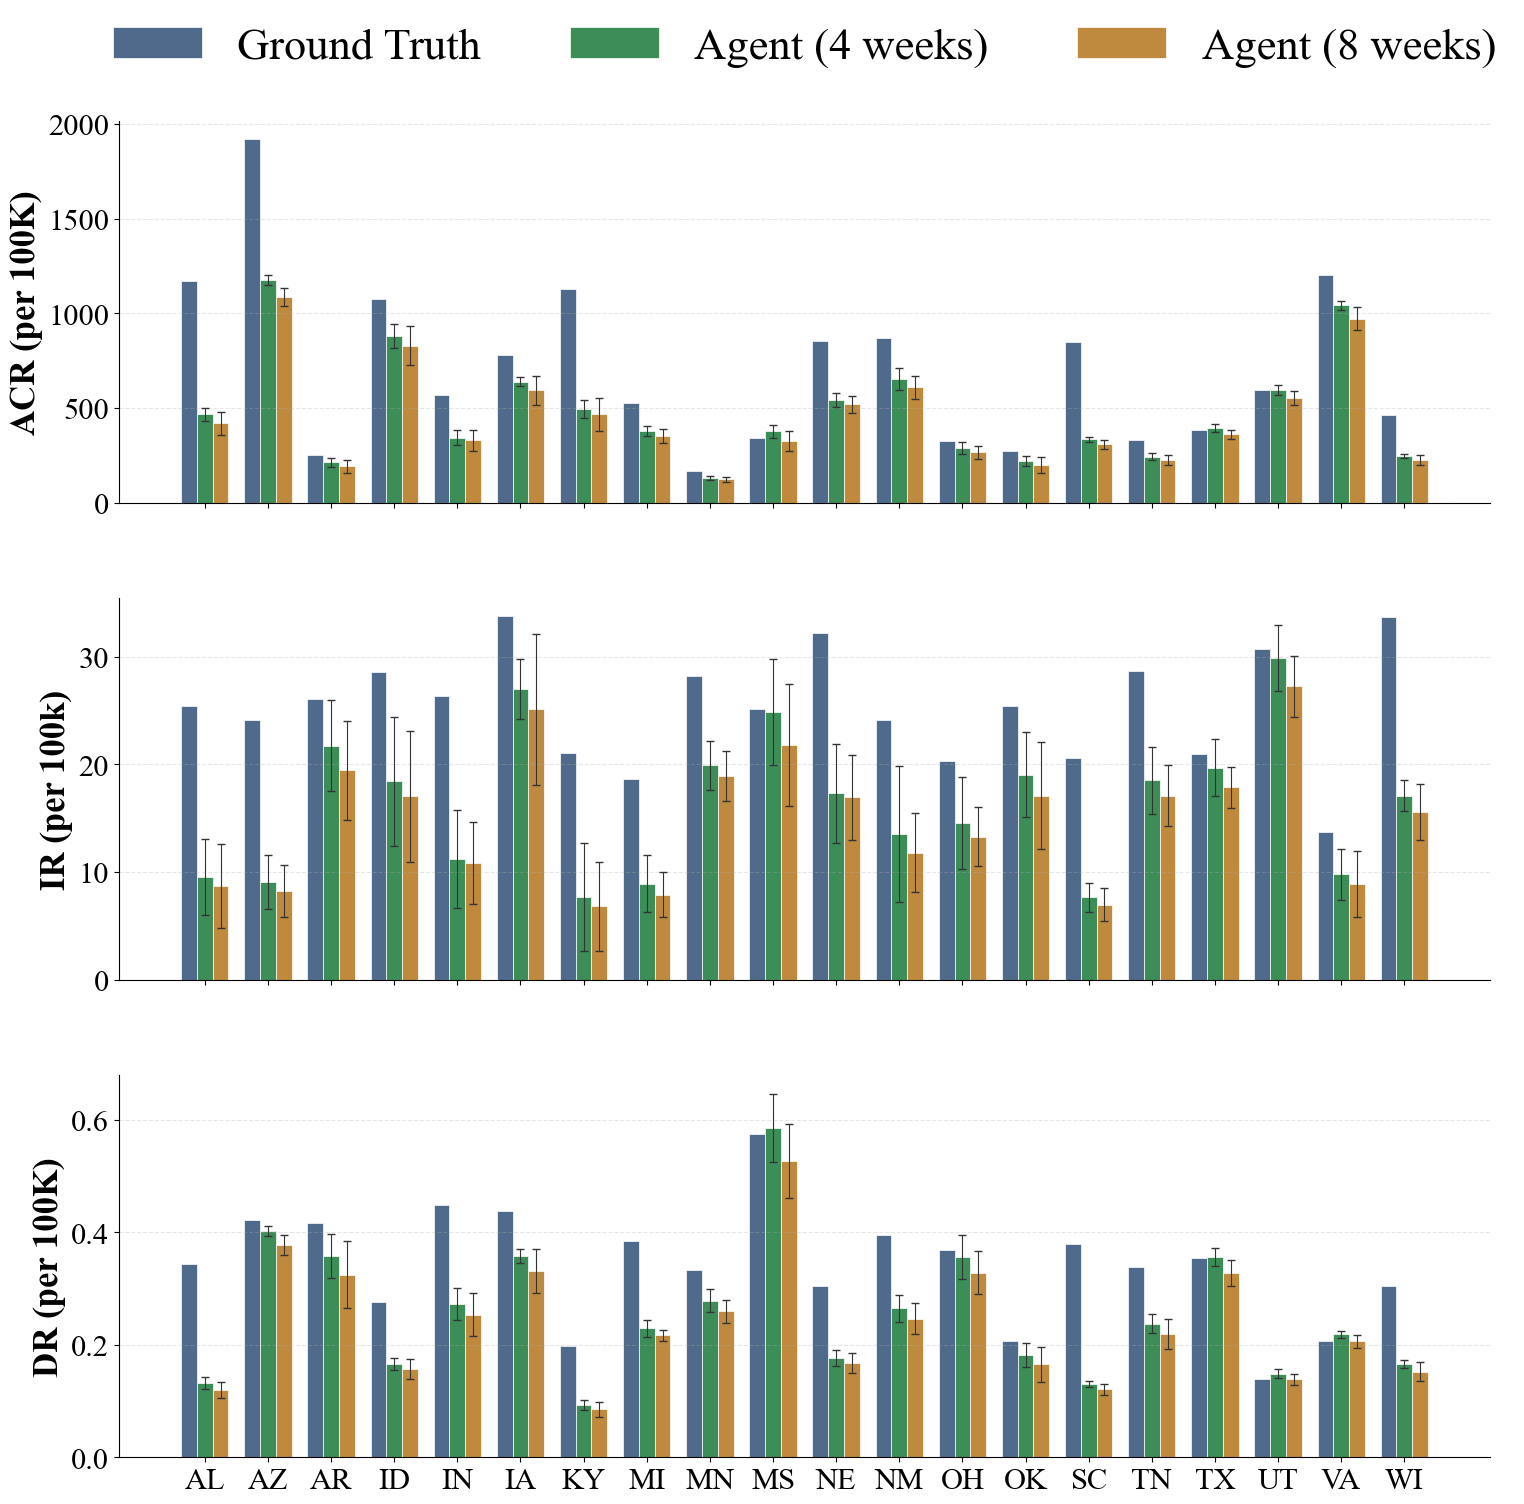

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams.update({
    "font.family": "Times New Roman",
    "mathtext.fontset": "stix",      
    "axes.unicode_minus": False      
})

week_freqs = ["4 weeks", "8 weeks"]
results_root = "..\\outputs\\US"
# 重新排序：ACR 放在第一个 (最上方)
metric_cols = ['active_case_ratio', 'incidence_rate_7d', 'death_incidence_7d']
y_labels = [
    'ACR (per 100K)',
    'IR (per 100k)',
    'DR (per 100K)'
]

# 配色方案
color_gt     = "#4F6A8A"   # Muted slate blue
color_4weeks = "#3C8D57"   # Green-ish
color_8weeks = "#C08A3E"   # Warm ochre
err_color    = "#333333"   # Dark grey for error bars

# 创建 3x1 的子图布局
fig, axes = plt.subplots(3, 1, figsize=(16, 15), sharex=True)

for ax_idx, metric_name in enumerate(metric_cols):
    ax = axes[ax_idx]
    ylabel = y_labels[ax_idx]

    gt_values, agent_values_4, agent_values_8 = [], [], []
    agent_stds_4, agent_stds_8 = [], []

    # 数据读取逻辑 (保持你原有的逻辑)
    for state in state_list:
        vals_gt_state = None
        vals_agent = {}
        for wf in week_freqs:
            results_folder = os.path.join(results_root, wf, "agent")
            metric_gt = pd.read_csv(os.path.join(results_folder, f"{state}_metrics_gt_{wf}.csv"))
            metric_mean = pd.read_csv(os.path.join(results_folder, f"{state}_metrics_mean_{wf}.csv"))
            metric_std = pd.read_csv(os.path.join(results_folder, f"{state}_metrics_std_{wf}.csv"))
            
            if vals_gt_state is None:
                vals_gt_state = metric_gt[metric_cols].mean(numeric_only=True)
            
            vals_agent[wf] = (metric_mean[metric_cols].mean(numeric_only=True), 
                              metric_std[metric_cols].mean(numeric_only=True))

        gt_values.append(vals_gt_state[metric_name])
        agent_values_4.append(vals_agent['4 weeks'][0][metric_name])
        agent_stds_4.append(vals_agent['4 weeks'][1][metric_name])
        agent_values_8.append(vals_agent['8 weeks'][0][metric_name])
        agent_stds_8.append(vals_agent['8 weeks'][1][metric_name])

    # 绘制柱状图
    n_states = len(state_list)
    x = np.arange(n_states)
    width = 0.25

    rects1 = ax.bar(x - width, gt_values, width, label='Ground Truth', color=color_gt, edgecolor='white', linewidth=0.5)
    rects2 = ax.bar(x, agent_values_4, width, yerr=agent_stds_4, capsize=3, label='Agent (4 weeks)', 
                    color=color_4weeks, edgecolor='white', linewidth=0.5, error_kw={'ecolor': err_color, 'elinewidth': 0.8})
    rects3 = ax.bar(x + width, agent_values_8, width, yerr=agent_stds_8, capsize=3, label='Agent (8 weeks)', 
                    color=color_8weeks, edgecolor='white', linewidth=0.5, error_kw={'ecolor': err_color, 'elinewidth': 0.8})

    # 细节修饰
    ax.set_ylabel(ylabel, fontsize=25, fontweight='bold')
    ax.tick_params(axis='y', labelsize=22)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # 如果是最上方的子图，设置图例
    if ax_idx == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=3, 
                  fontsize=32, frameon=False, columnspacing=2)

# 设置 x 轴
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(state_abbr, fontsize=22)
# axes[-1].set_xlabel('States', fontsize=18, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(hspace=0.25) # 调整子图垂直间距

# 保存
out_fig_path = '../figures/US/US_states_combined_metrics.png'
plt.savefig(out_fig_path, dpi=300, bbox_inches='tight')
plt.show()

In [23]:
import os

path = '../outputs/US/4 weeks/agent/alabama_metrics_gt_4 weeks.csv'
print(os.path.exists(path))

True
